# Recommender Systems part 2

# Milad Moradnia

# Collaborative Filtering

Collaborative filtering is the most common way to do product recommendation online. It’s “collaborative” because it predicts a given customers preferences on the basis of other customers.

* Collaborative filtering technique works by building a database (user-item matrix) of preferences for items by users.
* It then matches users with relevant interest and preferences by calculating similarities between their profiles to make recommendations.
* An user gets recommendations to those items that he has not rated before but that were already positively rated by users in his neighborhood.

![medium](https://miro.medium.com/max/1400/1*7uW5hLXztSu_FOmZOWpB6g.png)
source: [medium](https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0)

# Model-Based Collaborative Filtering

Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

* The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
* When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
* You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

> # Because we use big & sparse data, i prefer model-based approach for this dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [18, 8]

# Load Dataset & Data Cleaning

In [2]:
reviews = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/ratings.dat', names=['userId', 'movieId', 'rating', 'time'], delimiter='::', engine='python')
movies = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/movies.dat', names=['movieId', 'movie_names', 'genres'], delimiter='::', engine='python')
users = pd.read_csv('/kaggle/input/movielens-1m/ml-1m/users.dat', names=['userId', 'gender', 'age', 'occupation', 'zip'], delimiter='::', engine='python')

print('Reviews shape:', reviews.shape)
print('Users shape:', users.shape)
print('Movies shape:', movies.shape)

Reviews shape: (1000209, 4)
Users shape: (6040, 5)
Movies shape: (3883, 3)


In [3]:
reviews.drop(['time'], axis=1, inplace=True)
users.drop(['zip'], axis=1, inplace=True)

In [4]:
movies['release_year'] = movies['movie_names'].str.extract(r'(?:\((\d{4})\))?\s*$', expand=False)

In [5]:
movies.head()

,movieId,movie_names,genres,release_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


### Since we won't use age & occupation for prediction in this kernel, i changed this features value based on README from original datasets for better understanding in visualization

In [6]:
ages_map = {1: 'Under 18',
            18: '18 - 24',
            25: '25 - 34',
            35: '35 - 44',
            45: '45 - 49',
            50: '50 - 55',
            56: '56+'}

occupations_map = {0: 'Not specified',
                   1: 'Academic / Educator',
                   2: 'Artist',
                   3: 'Clerical / Admin',
                   4: 'College / Grad Student',
                   5: 'Customer Service',
                   6: 'Doctor / Health Care',
                   7: 'Executive / Managerial',
                   8: 'Farmer',
                   9: 'Homemaker',
                   10: 'K-12 student',
                   11: 'Lawyer',
                   12: 'Programmer',
                   13: 'Retired',
                   14: 'Sales / Marketing',
                   15: 'Scientist',
                   16: 'Self-Employed',
                   17: 'Technician / Engineer',
                   18: 'Tradesman / Craftsman',
                   19: 'Unemployed',
                   20: 'Writer'}

gender_map = {'M': 'Male', 'F': 'Female'}

users['age'] = users['age'].map(ages_map)
users['occupation'] = users['occupation'].map(occupations_map)
users['gender'] = users['gender'].map(gender_map)

### Merge all dataset

In [7]:
final_df = reviews.merge(movies, on='movieId', how='left').merge(users, on='userId', how='left')

print('final_df shape:', final_df.shape)

final_df shape: (1000209, 9)


In [8]:
final_df.head()

,userId,movieId,rating,movie_names,genres,release_year,gender,age,occupation
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,1975,Female,Under 18,K-12 student
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,1996,Female,Under 18,K-12 student
2,1,914,3,My Fair Lady (1964),Musical|Romance,1964,Female,Under 18,K-12 student
3,1,3408,4,Erin Brockovich (2000),Drama,2000,Female,Under 18,K-12 student
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,Female,Under 18,K-12 student


# Visualization

In [9]:
gender_counts = users['gender'].value_counts()

colors1 = ['dodgerblue', 'pink']

pie = go.Pie(labels=gender_counts.index,
             values=gender_counts.values,
             marker=dict(colors=colors1),
             hole=0.5)

layout = go.Layout(title='Male & Female users', font=dict(size=18), legend=dict(orientation='h'))

fig = go.Figure(data=[pie], layout=layout)
py.iplot(fig)

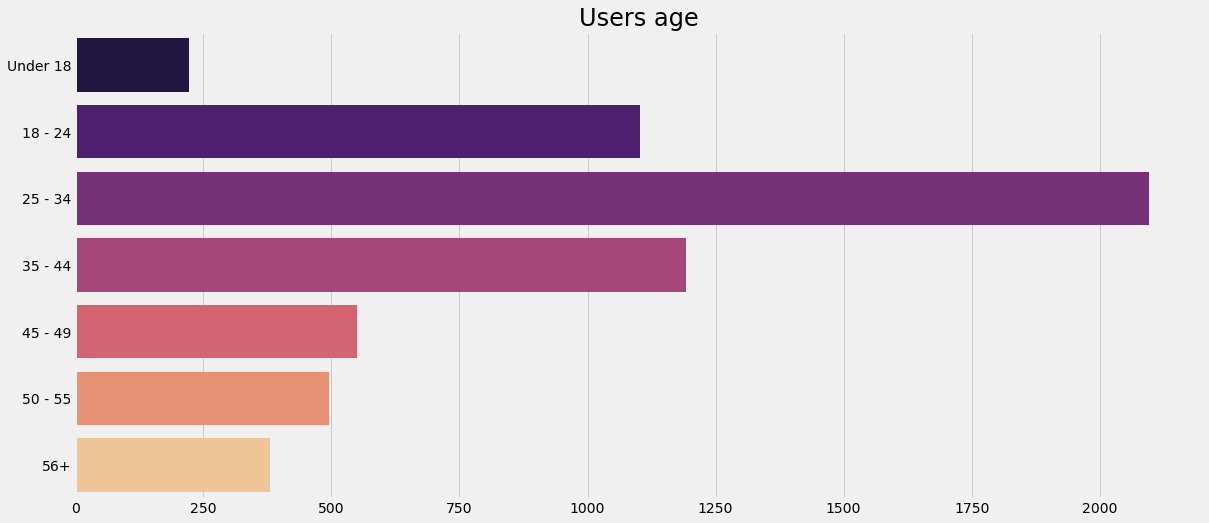

In [10]:
age_reindex = ['Under 18', '18 - 24', '25 - 34', '35 - 44', '45 - 49', '50 - 55', '56+']

age_counts = users['age'].value_counts().reindex(age_reindex)

sns.barplot(x=age_counts.values,
            y=age_counts.index,
            palette='magma').set_title(
                'Users age', fontsize=24)

plt.show()

* Wow, majority users age are from 25 - 34
* Let's check top-7 movies which is liked by them

In [11]:
final_df[final_df['age'] == '25 - 34']['movie_names'].value_counts()[:7]

American Beauty (1999)                                   1334
Star Wars: Episode V - The Empire Strikes Back (1980)    1176
Star Wars: Episode VI - Return of the Jedi (1983)        1134
Star Wars: Episode IV - A New Hope (1977)                1128
Terminator 2: Judgment Day (1991)                        1087
Silence of the Lambs, The (1991)                         1067
Matrix, The (1999)                                       1049
Name: movie_names, dtype: int64

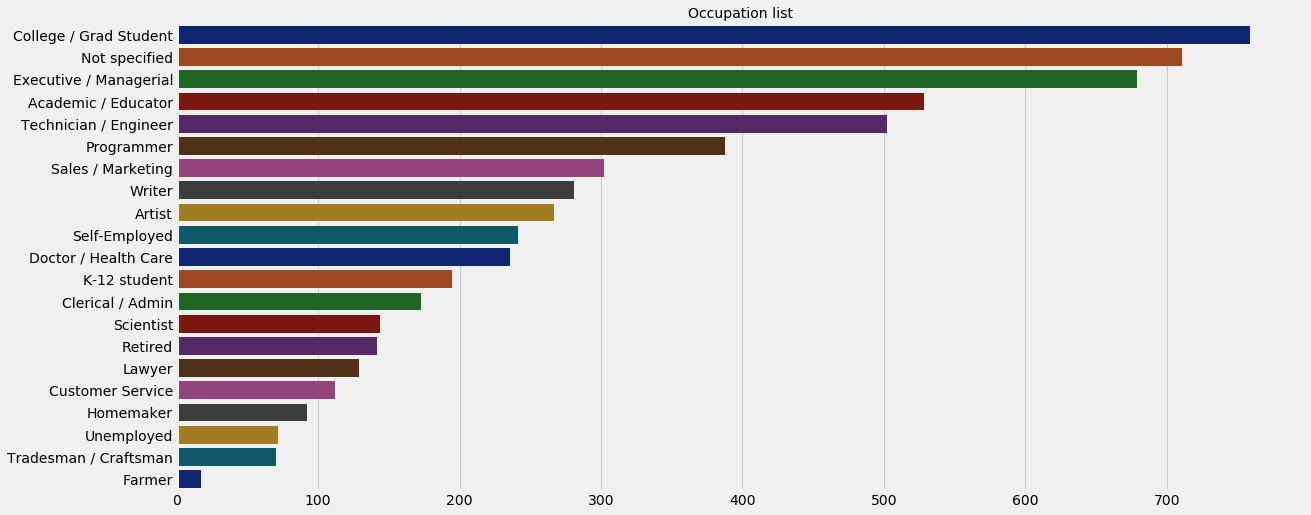

In [12]:
occupation_counts = users['occupation'].value_counts().sort_values(ascending=False)

sns.barplot(x=occupation_counts.values,
            y=occupation_counts.index,
            palette='dark').set_title(
                'Occupation list', fontsize=14)

plt.show()

# Support Vector Decomposition (SVD)

* A recommendation technique that is efficient when the number of dataset is limited may be unable to generate satisfactory number of recommendations when the volume of dataset is increased.
* Thus, it is crucial to apply recommendation techniques which are capable of scaling up in a successful manner as the number of dataset in a database increases.
* Methods used for solving scalability problem and speeding up recommendation generation are based on Dimensionality reduction techniques, such as Singular Value Decomposition (SVD) method, which has the ability to produce reliable and efficient recommendations.

> ###  use Surprise library 

# SurPRISE - Simple Python RecommendatIon System Engine.


In [26]:
from surprise import Reader, Dataset, SVD, SVDpp
from surprise import accuracy

In [27]:
reader = Reader(rating_scale=(1, 5))

dataset = Dataset.load_from_df(final_df[['userId', 'movieId', 'rating']], reader=reader)

svd = SVD(n_factors=50)
svd_plusplus = SVDpp(n_factors=50)

In [28]:
trainset = dataset.build_full_trainset()

svd.fit(trainset)  # old version use svd.train

In [29]:
### It will take a LONG....TIME...., but it'll give a better score in RMSE & MAE

# svd_plusplus.fit(trainset)

In [30]:
id_2_names = dict()

for idx, names in zip(movies['movieId'], movies['movie_names']):
    id_2_names[idx] = names

In [31]:
def Build_Anti_Testset4User(user_id):
    
    fill = trainset.global_mean
    anti_testset = list()
    u = trainset.to_inner_uid(user_id)
    
    # ur == users ratings
    user_items = set([item_inner_id for (item_inner_id, rating) in trainset.ur[u]])
    
    anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                            i in trainset.all_items() if i not in user_items]
    
    return anti_testset

### First, let's try SVD for make Top-N recommendation

In [32]:
def TopNRecs_SVD(user_id, num_recommender=10, latest=False):
    
    testSet = Build_Anti_Testset4User(user_id)
    predict = svd.test(testSet)  # we can change to SVD++ later
    
    recommendation = list()
    
    for userID, movieID, actualRating, estimatedRating, _ in predict:
        intMovieID = int(movieID)
        recommendation.append((intMovieID, estimatedRating))
        
    recommendation.sort(key=lambda x: x[1], reverse=True)
    
    movie_names = []
    movie_ratings = []
    
    for name, ratings in recommendation[:20]:
        movie_names.append(id_2_names[name])
        movie_ratings.append(ratings)
        
    movie_dataframe =  pd.DataFrame({'movie_names': movie_names,
                                     'rating': movie_ratings}).merge(movies[['movie_names', 'release_year']],
                                            on='movie_names', how='left')
    
    if latest == True:
        return movie_dataframe.sort_values('release_year', ascending=False)[['movie_names', 'rating']].head(num_recommender)
    
    else:
        return movie_dataframe.drop('release_year', axis=1).head(num_recommender)

### First option:

* Sort by predicted rating
* Sometimes system will recommend an old movie
* If users doesn't like old movie, it'll become a problem

In [33]:
TopNRecs_SVD(1920, num_recommender=10)

,movie_names,rating
0,"Patriot, The (2000)",4.638616
1,Remember the Titans (2000),4.612634
2,Sanjuro (1962),4.521879
3,Sleepless in Seattle (1993),4.486422
4,Gladiator (2000),4.436806
5,Double Jeopardy (1999),4.435193
6,"Children of Heaven, The (Bacheha-Ye Aseman) (1...",4.423375
7,You've Got Mail (1998),4.390629
8,"King of Masks, The (Bian Lian) (1996)",4.363488
9,Notting Hill (1999),4.355601


### Second option:

* Sort by release year
* System will recommend the latest movies
* But the best predicted rating will go down from the top

In [34]:
TopNRecs_SVD(1920, num_recommender=10, latest=True)

,movie_names,rating
0,"Patriot, The (2000)",4.638616
17,U-571 (2000),4.236332
4,Gladiator (2000),4.436806
1,Remember the Titans (2000),4.612634
5,Double Jeopardy (1999),4.435193
14,"Green Mile, The (1999)",4.281517
9,Notting Hill (1999),4.355601
12,American History X (1998),4.289313
7,You've Got Mail (1998),4.390629
6,"Children of Heaven, The (Bacheha-Ye Aseman) (1...",4.423375


## Model Evaluation

In [35]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions_svd = svd.test(testset)

In [36]:
print('SVD - RMSE:', accuracy.rmse(predictions_svd, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions_svd, verbose=False))

SVD - RMSE: 0.6991122048631789
SVD - MAE: 0.5412307631229801
